In [1]:
from __future__ import print_function
import sys
import rospy
import time
import tf
import jupyros as jr
from geometry_msgs.msg import Point, Pose, Twist
from nav_msgs.msg import Odometry
import actionlib
import actionlib.msg
import second_assignment.msg
from second_assignment.msg import Pos_vel
from second_assignment.msg import PlanningAction, PlanningGoal, PlanningResult
from std_srvs.srv import SetBool
from actionlib_msgs.msg import GoalStatus
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tf.transformations import quaternion_matrix
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import VBox, HBox   

In [2]:
global x
global y 
global client
global var
global goal_reached
global latest_feedback
global goal_list
global num_reached_goals
global num_goal_not_reached
global first_goal
global prev_not_reached

num_reached_goals = 0
num_goal_not_reached = 0
prev_not_reached = 0
first_goal = False
goal_list = []

rospy.init_node('node_action_client')
client = actionlib.SimpleActionClient('/reaching_goal', second_assignment.msg.PlanningAction)

In [3]:
def feedback_cb(feedback):
    global latest_feedback
    latest_feedback = feedback

In [4]:
# Create a publisher that will publish to the 'goal_list' topic to display the goals in the map
pub = rospy.Publisher('goal_list', Pos_vel, queue_size=10)

# Widgets for the user to input the goal coordinates and confirm them with a button
x_input = widgets.Text(description='x coordinate:', continuous_update=False)
y_input = widgets.Text(description='y coordinate:', continuous_update=False)
button = widgets.Button(description="Confirm")

x, y = None, None
goal_list = []

# Functions to handle the user input and the button click
def handle_x_input(change):
    global x
    x = float(change.new)

def handle_y_input(change):
    global y
    y = float(change.new)

def on_button_clicked(b):
    global x, y, first_goal
    print("User input for x:", x)
    print("User input for y:", y)
    # Set the first goal to True in order to allow the display of the histogram
    first_goal = True
    # Send the goal to the action server using a custom send_goal function
    send_goal() 

x_input.observe(handle_x_input, names='value')
y_input.observe(handle_y_input, names='value')

# Set the on_click event of the button
button.on_click(on_button_clicked)

def send_goal():
    global x
    global y
    global goal_list
    client.wait_for_server()
    
    rospy.set_param('/des_pos_x', x)
    rospy.set_param('/des_pos_y', y)
    
    pos_vel = Pos_vel()
    pos_vel.x = x
    pos_vel.y = y

    goal_list.append([x,y])
    
    # Publish the goal to the topic goal_list to be displayed in the map
    pub.publish(pos_vel)

    goal = second_assignment.msg.PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    client.send_goal(goal, feedback_cb=feedback_cb)

# Widgets for the user to cancel the goal and display the goals sent
cancel_button = widgets.Button(description="Cancel Goal")
goal_sent_button = widgets.Button(description="Display Goal Sent")

# Function to handle the button click to cancel the goal
def on_cancel_button_clicked(b):
    global num_goal_not_reached 
    global prev_not_reached
    client.cancel_goal()
    rospy.loginfo("Goal cancelled")
    # Increment the number of goals not reached
    num_goal_not_reached = num_goal_not_reached  + 1
    # Store the previous number of goals not reached which is the current number of goals not reached - 1
    prev_not_reached = num_goal_not_reached - 1 
    time.sleep(0.1)
    print("Reinsert the goal and confirm it using the Confirm button")
    x_input.observe(handle_x_input, names='value')
    y_input.observe(handle_y_input, names='value')

    button.on_click(on_button_clicked)

def on_goal_sent_button_clicked(b):
    print("List of goals sent: ", goal_list)

cancel_button.on_click(on_cancel_button_clicked)
goal_sent_button.on_click(on_goal_sent_button_clicked)

# Display the widgets in a particurlar layout
left_box = VBox([x_input, y_input, button])
right_box = VBox([cancel_button, goal_sent_button])
HBox([left_box, right_box])



User input for x: 2.0
User input for y: 2.0


In [5]:
# Class to visualize the robot's path and the goals in the map using matplotlib, it's the one from the slides
# with some modifications to display the goals (the target callback) that exploits the publisher created above with the custom message used
# in the assignment in the first semester
class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')  
        self.ln_target, = plt.plot([], [], 'bo')
        self.x_data, self.y_data = [], []
        self.x_target_data, self.y_target_data = [], []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln, self.ln_target

    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)

    def target_callback(self, msg):
        self.y_target_data.append(msg.x)
        self.x_target_data.append(msg.y)

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        self.ln_target.set_data(self.x_target_data, self.y_target_data)
        return self.ln, self.ln_target

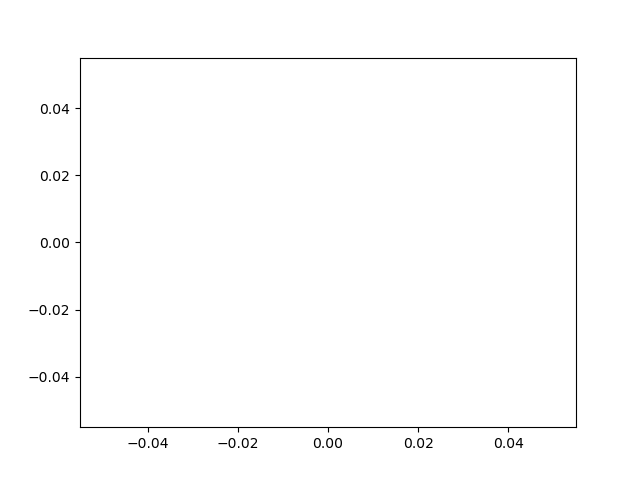

Number of goals reached:  1
Number of goals not reached:  0


In [6]:
%matplotlib widget

vis = Visualiser()
# subscriber to the topic odom to get the position of the robot 
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)

# subscriber to the topic goal_list to get the target position that is continuously updated
sub_2 = rospy.Subscriber('/goal_list', Pos_vel, vis.target_callback)

ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init, blit=True)
plt.show(block=True)

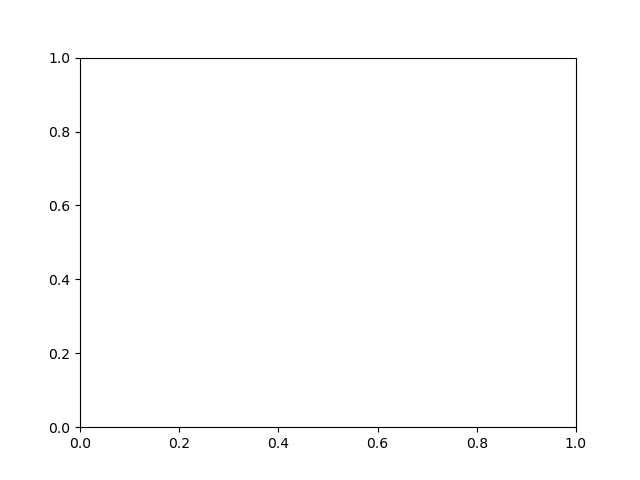

In [7]:

global pos_vel
pos_vel = Pos_vel()

# Define labels for the bar chart
labels = ['Reached Goals', 'Not Reached Goals']

# Create a new figure and a set of subplots
fig, ax = plt.subplots()

def position_callback(message):
    global pos_vel
    global first_goal
    global num_reached_goals
    global num_goal_not_reached
    global goal_list
    global prev_not_reached
    pos_vel.x = message.pose.pose.position.x
    pos_vel.y = message.pose.pose.position.y

    # Calculate the difference between the number of goals not reached and the previous number of goals not reached
    diff = num_goal_not_reached - prev_not_reached
    # If a goal is sent
    if first_goal == True:
        # If the robot reaches the goal
        if (pos_vel.x - 0.5 < x < pos_vel.x + 0.5 and pos_vel.y - 0.5 < y < pos_vel.y + 0.5): 
            # Increment the number of goals reached
            num_reached_goals = num_reached_goals + 1
            first_goal = False

            print("Number of goals reached: ", num_reached_goals)
            print("Number of goals not reached: ", num_goal_not_reached)

            # Plot the istogram with the updated values
            ax.clear()
            values = [num_reached_goals, num_goal_not_reached]
            ax.bar(labels, values)
            ax.set_title('Goals Status')
            ax.set_ylabel('Number of Goals')

        # If a goal has been cancelled
        elif diff != 0:
            # Set the previous number of goals not reached to the current number of goals not reached
            prev_not_reached = num_goal_not_reached
            first_goal = False
            
            ax.clear()
            values = [num_reached_goals, num_goal_not_reached]
            ax.bar(labels, values)
            ax.set_title('Goals Status')
            ax.set_ylabel('Number of Goals')


sub_3 = rospy.Subscriber('/odom', Odometry, position_callback)

ani_2 = FuncAnimation(fig, position_callback, frames=range(100), repeat=False)
plt.show()